In [90]:
from google.colab import files

# Opens a file-picker in Colab so you can choose your photo
uploaded = files.upload()

Saving IMG_6227.HEIC to IMG_6227 (4).HEIC


In [91]:
# Converts iPhone HEIC images to JPG so Python can read them
!pip -q install pillow pillow-heif

from PIL import Image
import pillow_heif

input_path = list(uploaded.keys())[0]  # automatically get uploaded file name and converts to jpg
output_path = input_path.rsplit(".", 1)[0] + "_converted.jpg"

heif_file = pillow_heif.read_heif(input_path)
image = Image.frombytes(
    heif_file.mode, heif_file.size, heif_file.data, "raw"
)
image.save(output_path, format="JPEG")

print(f"✅ Converted {input_path} → {output_path}")



✅ Converted IMG_6227 (4).HEIC → IMG_6227 (4)_converted.jpg


Using image: IMG_6227 (4)_converted.jpg


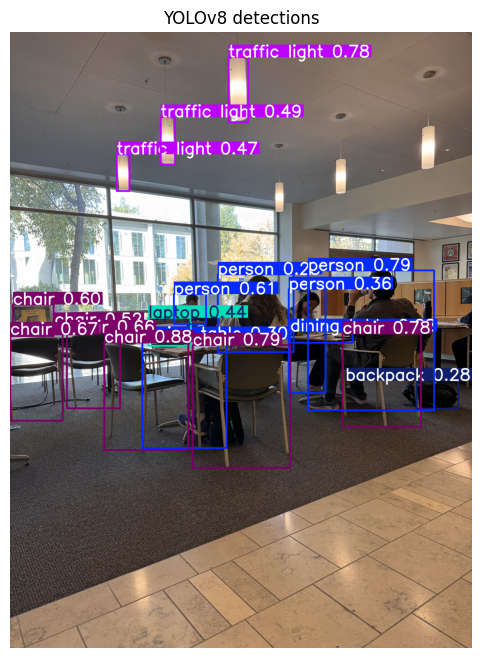

Detections: [{'label': 'chair', 'conf': 0.879, 'xyxy': [874.417724609375, 2876.274169921875, 1653.80322265625, 3876.276611328125]}, {'label': 'person', 'conf': 0.789, 'xyxy': [2763.953857421875, 2210.855712890625, 3932.043701171875, 3508.596435546875]}, {'label': 'chair', 'conf': 0.786, 'xyxy': [1694.503662109375, 2903.270263671875, 2599.868408203125, 4042.961669921875]}, {'label': 'traffic light', 'conf': 0.778, 'xyxy': [2026.8843994140625, 232.4215850830078, 2208.480224609375, 838.3445434570312]}, {'label': 'chair', 'conf': 0.777, 'xyxy': [3083.088134765625, 2794.43505859375, 3809.031005859375, 3661.5712890625]}, {'label': 'chair', 'conf': 0.665, 'xyxy': [2.233769416809082, 2804.77734375, 488.5245056152344, 3604.4658203125]}, {'label': 'chair', 'conf': 0.657, 'xyxy': [527.4905395507812, 2784.066162109375, 1021.8050537109375, 3489.9658203125]}, {'label': 'person', 'conf': 0.612, 'xyxy': [1519.01416015625, 2429.492919921875, 1817.6407470703125, 2707.52978515625]}, {'label': 'chair', 'c

In [92]:
# --- YOLOv8: draw boxes + labels on an image and display/save the result ---

# 1) Install & imports
!pip -q install ultralytics opencv-python
from ultralytics import YOLO
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# 2) Resolve an input image path
IMAGE_PATH = None
try:
    # If you ran the HEIC->JPG cell earlier, it defined `output_path`
    if 'output_path' in globals() and os.path.exists(output_path):
        IMAGE_PATH = output_path
except Exception:
    pass

if IMAGE_PATH is None:
    # Fall back to a file picker
    from google.colab import files
    uploaded = files.upload()
    IMAGE_PATH = next(iter(uploaded.keys()))

print(f"Using image: {IMAGE_PATH}")

# 3) Load a lightweight pretrained YOLOv8 model (swap to yolov8s.pt / yolov8m.pt for stronger)
model = YOLO("yolov8n.pt")

# 4) Run inference
results = model(IMAGE_PATH, verbose=False)[0]   # first (and only) image's result

# 5) Render annotated image (results.plot() returns a BGR numpy array)
annot_bgr = results.plot()
annot_rgb = cv2.cvtColor(annot_bgr, cv2.COLOR_BGR2RGB)

# 6) Show inline
plt.figure(figsize=(10, 8))
plt.imshow(annot_rgb)
plt.axis("off")
plt.title("YOLOv8 detections")
plt.show()

# 7) Print detections (label + confidence)
names = model.names
det_list = []
for b in results.boxes:
    cls = int(b.cls[0].item())
    conf = float(b.conf[0].item())
    x1, y1, x2, y2 = map(float, b.xyxy[0].tolist())
    det_list.append({"label": names[cls], "conf": round(conf, 3), "xyxy": [x1, y1, x2, y2]})
print("Detections:", det_list)

# 8) Save annotated image next to the input
base, ext = os.path.splitext(IMAGE_PATH)
out_path = f"{base}_yolo_annotated.jpg"
cv2.imwrite(out_path, annot_bgr)  # keep as BGR for cv2.imwrite
print(f"Saved annotated image → {out_path}")


In [93]:
!pip -q install "openai>=1.40.0"

from openai import OpenAI
import base64, json, os



In [94]:
from getpass import getpass
import os
from openai import OpenAI

# When you run this, Colab will prompt you to paste your key securely
os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key (starts with sk-): ")

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])



Enter your OpenAI API key (starts with sk-): ··········


In [95]:
try:
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": "Say hello"}],
        max_tokens=10
    )
    print("✅ API key works! Model replied:", resp.choices[0].message.content)
except Exception as e:
    print("⚠️ Error:", e)


✅ API key works! Model replied: Hello! How can I assist you today?


In [96]:
def encode_image_to_b64(path):
    """Convert image to Base64 for GPT-Vision"""
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")


In [97]:
image_path = output_path  # the converted JPG

response = client.chat.completions.create(
    model="gpt-4o-mini",  # or "gpt-4.1" for full Vision
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text",
                 "text": (
                     "Describe what you see in this image and identify the environment type "
                     "(classroom, office, store, etc.).")},
                {"type": "image_url",
                 "image_url": {
                     "url": f"data:image/jpeg;base64,{encode_image_to_b64(image_path)}",
                     "detail": "low"  # 'low' is fast, 'high' for detailed reasoning
                 }},
            ],
        }
    ],
)

print(response.choices[0].message.content)


The image depicts an interior space that resembles a study area or a library setting. It features several individuals seated at tables, engaging with their laptops or studying materials. The lighting is bright, provided by pendant lights hanging from the ceiling. There are large windows in the background, indicating a well-lit environment with a view of greenery outside. The overall atmosphere appears calm and conducive to studying or group work, suggesting it is a collaborative learning space or study lounge.


In [98]:
prompt = (
    "You are a robot vision module. Analyze this image and return JSON with: "
    "room_type (string), confidence (0-1), rationale (string), key_objects (array)."
)

response_json = client.chat.completions.create(
    model="gpt-4o-mini",
    response_format={"type": "json_object"},
    messages=[
        {"role": "system", "content": prompt},
        {"role": "user", "content": [
            {"type": "image_url",
             "image_url": {"url": f"data:image/jpeg;base64,{encode_image_to_b64(image_path)}"}}
        ]},
    ],
)

print(json.loads(response_json.choices[0].message.content))


{'room_type': 'study area', 'confidence': 0.9, 'rationale': "The image shows a well-lit space with multiple tables and chairs, suggesting it's designed for studying or group work. People are engaged in activities like working on laptops and taking notes, which further indicates this is a study area.", 'key_objects': ['tables', 'chairs', 'laptop', 'notebook', 'people']}
